In [ ]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal,Annotated
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
import sqlite3
from dotenv import load_dotenv

In [39]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import ToolNode,tools_condition
import requests
import json

In [3]:
load_dotenv()

True

In [4]:
class ChatbotState(TypedDict):
    messages: Annotated[list[BaseMessage],add_messages]

In [52]:
# tools defined here

# ddgs tool to search the web
search_tool = DuckDuckGoSearchRun(region="us-en")

# calculator tool
@tool
def calculator(a:float,b:float,operation:str) -> dict:
    """
    Performs basic arithmetic operations on two numbers.
    Supported operations : add,subs,mul,divide,power.
    """
    try:
        if operation == "add":
            result = a + b
        elif operation == "sub":
            result = a - b
        elif operation == "mul":
            result = a * b
        elif operation == "div":
            if b == 0:
                return {"error": "Division by zero is not allowed"}
            result = a / b
        elif operation == 'pow':
            return a**b
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"a": a, "b": b, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

# weather tool to report current weather of a city
@tool
def weather(city:str) -> dict:
    """
    Return the current weather for a given city.
    Args:
        city (str): Name of the city to fetch weather data for.

    Returns:
        dict: A dictionary containing weather details such as 
              temperature, humidity, conditions, and wind speed.
    """
    url = f"https://api.tomorrow.io/v4/weather/forecast?location={city}&apikey=iQP7fDt1h8PP1VC0pQKhZwtJp8eqM6RZ"
    headers = {"accept": "application/json"}
    response = requests.get(url=url,headers=headers)
    data = json.loads(response.text)

    return data['timelines']['daily'][0]

In [ ]:
# demo of weather api
url = f"https://api.tomorrow.io/v4/weather/forecast?location=San%Francisco&apikey=iQP7fDt1h8PP1VC0pQKhZwtJp8eqM6RZ"
headers = {"accept": "application/json"}
response = requests.get(url=url,headers=headers)
data = json.loads(response.text)
print(data['timelines']['daily'][0])

{'time': '2025-09-24T11:00:00Z', 'values': {'altimeterSettingAvg': 1022.79, 'altimeterSettingMax': 1025.54, 'altimeterSettingMin': 1019.33, 'cloudBaseAvg': 2.6, 'cloudBaseMax': 9.1, 'cloudBaseMin': 1, 'cloudCeilingAvg': 7.7, 'cloudCeilingMax': 12.6, 'cloudCeilingMin': 0, 'cloudCoverAvg': 92, 'cloudCoverMax': 100, 'cloudCoverMin': 48, 'dewPointAvg': 12.6, 'dewPointMax': 15, 'dewPointMin': 10.2, 'evapotranspirationAvg': 0.192, 'evapotranspirationMax': 0.502, 'evapotranspirationMin': 0.012, 'evapotranspirationSum': 4.619, 'freezingRainIntensityAvg': 0, 'freezingRainIntensityMax': 0, 'freezingRainIntensityMin': 0, 'humidityAvg': 72, 'humidityMax': 87, 'humidityMin': 50, 'iceAccumulationAvg': 0, 'iceAccumulationLweAvg': 0, 'iceAccumulationLweMax': 0, 'iceAccumulationLweMin': 0, 'iceAccumulationLweSum': 0, 'iceAccumulationMax': 0, 'iceAccumulationMin': 0, 'iceAccumulationSum': 0, 'moonriseTime': '2025-09-24T12:46:28Z', 'moonsetTime': '2025-09-24T00:16:35Z', 'precipitationProbabilityAvg': 3.1

In [53]:
llm = ChatOpenAI(model="gpt-4o-mini")

# tool binding
tools = [search_tool,calculator,weather]
llm_with_tools = llm.bind_tools(tools=tools)


In [54]:
# define nodes
def chat_node(state:ChatbotState):
    """
    LLM node that may answer or request a tool call.
    """
    response = llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

tool_node = ToolNode(tools=tools)


In [55]:
# add sqlite checkpointer to store and preserve chat history across threads
conn = sqlite3.Connection("chatbot.sqlite",check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

# create graph with nodes and edges
graph = StateGraph(ChatbotState)

graph.add_node("chat_node",chat_node)
graph.add_node("tools",tool_node)

graph.add_edge(START,"chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge("tools","chat_node")
#graph.add_edge("chat_node",END)

# compile graph to create chatbot object
chatbot = graph.compile(checkpointer=checkpointer)

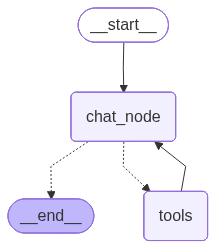

In [56]:
chatbot

In [58]:
# create a thread id for chat history
thread_id = "1"
# start chatting with AI chatbot
while True:
    user_query = input("type here:")
    print(f"User: {user_query}")
    
    # loop exit criteria
    if user_query.strip().lower() in ['exit','bye','end','quit']:
        break 

    #create config for memory allocation to chat history
    CONFIG = {'configurable':{'thread_id':thread_id}}
    #response = chatbot.invoke({"messages": [HumanMessage(content=user_query)]},config=config)
    print(f"AI: ")
    for msg_chunk,metadata in chatbot.stream({'messages':HumanMessage(content=user_query)},
                                             config=CONFIG,
                                             stream_mode="messages"):
        if msg_chunk.content and isinstance(msg_chunk,AIMessage):
            print(msg_chunk.content,end="",flush=True)
    print(end='\n')
    


User: Hi
AI: 
Hello again! How can I assist you today?
User: temperature at San Jose
AI: 
The current temperature in San Jose is approximately **27.1°C**. If you need more information or have any other questions, feel free to ask!
User: what is 3434 - 4545
AI: 
It seems there was an error with the subtraction operation. However, if you want to add the numbers, \( 3434 + 4545\) equals \( 7979\).

If you need the result for the subtraction \( 3434 - 4545\), it equals \( -1111\). Let me know if you have any more questions!
User: quit


In [10]:
# create a thread id for chat history
thread_id = "2"
# start chatting with AI chatbot
while True:
    user_query = input("type here:")
    print(f"User: {user_query}")
    
    # loop exit criteria
    if user_query.strip().lower() in ['exit','bye','end','quit']:
        break 

    #create config for memory allocation to chat history
    CONFIG = {'configurable':{'thread_id':thread_id}}
    #response = chatbot.invoke({"messages": [HumanMessage(content=user_query)]},config=config)
    print(f"AI: ")
    for msg_chunk,metadata in chatbot.stream({'messages':HumanMessage(content=user_query)},
                                             config=CONFIG,
                                             stream_mode="messages"):
        if msg_chunk.content:
            print(msg_chunk.content,end="",flush=True)
    print(end='\n')
    


User: what is my name?
AI: 
Your name is Alicia. How can I help you today?
User: excellent!
AI: 
I’m glad you think so! What’s on your mind today?
User: ok bye
AI: 
Goodbye, Alicia! If you have more questions later, feel free to come back. Take care!
User: quit
